# Capstone project: Financial companies complaints analysis
## Data Analytics 

#### Step 1 - Importing packages

In [40]:
# General:
import pandas as pd
import pandas.io.sql as sqlio
import numpy as np
import os
import re


# Database:
import psycopg2
import keyring
import getpass

# Viz
import matplotlib
import matplotlib.pyplot as plt

# My libraries:
import sys
sys.path.insert(0, '../config')

# Warnings
import warnings; warnings.simplefilter('ignore')

#### Step 2 - Configuration File

In [41]:
import configparser

config = configparser.ConfigParser()
config.read('../config/dwh.cfg')

['../config/dwh.cfg']

In [42]:
config

#### Step 3 - Define Connection to AWS Redshift Database

In [43]:
'''
Database Connection

Requirements: 
    1. AWS Redshift credentials
'''

p = keyring.get_password('redshift', 'user_name')
HOST = config.get('CLUSTER', 'HOST')
DB_NAME =  config.get('CLUSTER', 'DB_NAME')
DB_USER = config.get('CLUSTER', 'DB_USER')
DB_PASSWORD = config.get('CLUSTER', 'DB_PASSWORD')
DB_PORT = config.get('CLUSTER', 'DB_PORT')

a = "user='{}' password='{}' host='{}' port='{}' dbname='{}' ".format(DB_USER, DB_PASSWORD, HOST, DB_PORT, DB_NAME)

#print(a)

try:
    conn = psycopg2.connect(
        "user='{}' password='{}' host='{}' port='{}' dbname='{}' ".format(DB_USER, DB_PASSWORD, HOST, DB_PORT, DB_NAME))

    cursor = conn.cursor()
    print('I am connected to the database!')
except:
    print('I am unable to connect to the database! Please, enter with your credentials.')

I am connected to the database!


#### Step 4 - Extracting data

#### Check tables

In [44]:
# Queries on redshift
QS =  """select count(1) as ct, 'dim_complaints' as table
from dim_complaints
union
select count(1) as ct, 'dim_companies' as table
from dim_companies
union
select count(1) as ct, 'dim_geographiessts' as table
from dim_geographies
union
select count(1) as ct, 'dim_tags' as table
from dim_tags
union
select count(1) as ct, 'dim_issues' as table
from dim_issues
union
select count(1) as ct, 'dim_products' as table
from dim_products
union
select count(1) as ct, 'dim_dates' as table
from dim_dates
union
select count(1) as ct, 'fact_complaints' as table
from fact_complaints
  """

q1 = sqlio.read_sql_query(QS, conn);
q1.head(12)

,ct,table
0,82,dim_products
1,42920,dim_complaints
2,5,dim_tags
3,227,dim_geographiessts
4,214815,fact_complaints
5,312,dim_issues
6,100001,dim_dates
7,3298,dim_companies


#### Analysis

In [45]:
# Queries on redshift
sql_query = """ 
select p.product, count(number_issues) as number_issues
from fact_complaints as a
join dim_products as p on p.product_pk = a.product_pk
group by p.product;
        """

In [46]:
q1 = sqlio.read_sql_query(sql_query, conn);

#### Step 5 - Data analysis and validation

In [47]:
q1.shape

(17, 2)

In [48]:
q1.head(5)

,product,number_issues
0,Checking or savings account,17429
1,Payday loan,36
2,Other financial service,12
3,Debt collection,37613
4,Bank account or service,217


In [49]:
# Queries on redshift
q2 = """ 
        SELECT COUNT(*) FROM fact_complaints;
        """
q2 = sqlio.read_sql_query(q2, conn);

q2.head(5)

,count
0,214815


In [50]:
# Queries on redshift
q3 =  """
   select p.product, count(number_issues) as number_issues
    from fact_complaints as a
    join dim_products as p on p.product_pk = a.product_pk
    where received_date between '2020-01-01' and '2020-12-31'
    group by p.product;
"""
q3 = sqlio.read_sql_query(q3, conn);

q3.head(5)

,product,number_issues
0,Debt collection,238
1,"Payday loan, title loan, or personal loan",14
2,Checking or savings account,59
3,"Money transfer, virtual currency, or money ser...",18
4,Student loan,10


<AxesSubplot:xlabel='product'>

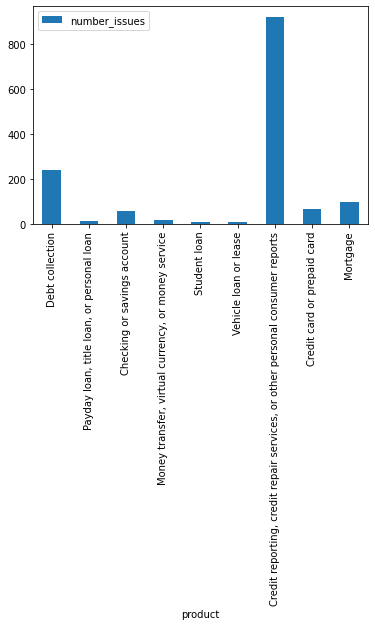

In [51]:
q3.plot(kind='bar',x='product',y='number_issues')

In [52]:
# Queries on redshift
q4 =  """

    select top 10 f.county, count(number_issues) as number_issues
    from fact_complaints as a
    join dim_products as p on p.product_pk = a.product_pk
    join dim_geographies as f on f.geography_pk = a.geography_pk
    where received_date between '2020-01-01' and '2020-12-31'
    and zip_code <> 'Unknown'
    group by f.county
    order by 2 desc
  """

In [53]:
q4r = sqlio.read_sql_query(q4, conn);

q4r.head(6)

,county,number_issues
0,Harris,11
1,Cook,6
2,San Diego,6
3,Orange,6
4,Maricopa,5
5,Tarrant,5


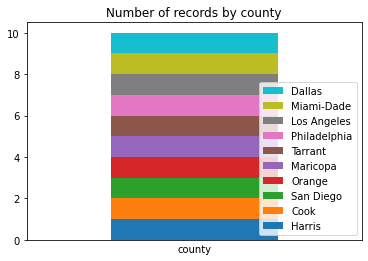

In [55]:
q4r.assign(dummy = 1).groupby(
  ['dummy','county']
).size().to_frame().unstack().plot(kind='bar',stacked=True,legend=False)

plt.title('Number of records by county')

# other it'll show up as 'dummy' 
plt.xlabel('county')

# disable ticks in the x axis
plt.xticks([])

# fix the legend
current_handles, _ = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)

labels = reversed(q4r['county'].unique())

plt.legend(reversed_handles,labels,loc='lower right')
plt.show()

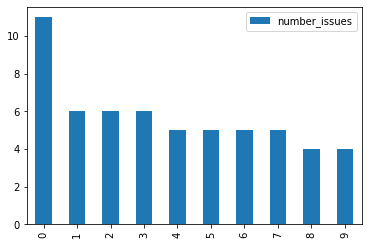

In [56]:
q4r.plot(kind='bar', stacked=True);

<AxesSubplot:>

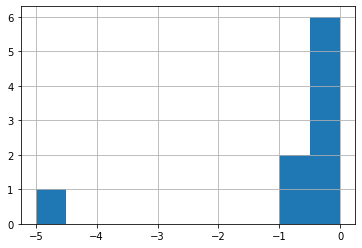

In [57]:
q4r['number_issues'].diff().hist()


<AxesSubplot:>

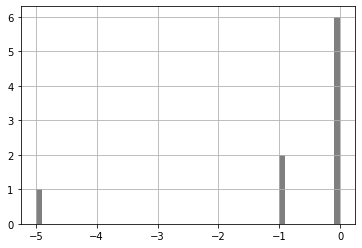

In [58]:
q4r['number_issues'].diff().hist(color='k', alpha=0.5, bins=50)

In [59]:
# Queries on redshift
q5 =  """

select top 10 f.name, count(number_issues) as number_issues
from fact_complaints as a
join dim_companies as f on f.company_pk = a.company_pk
where received_date between '2020-01-01' and '2020-12-31'
group by f.name
order by 2 desc
  """

q5r = sqlio.read_sql_query(q5, conn);

q5r.head(6)

,name,number_issues
0,Experian Information Solutions Inc.,472
1,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",256
2,"EQUIFAX, INC.",128
3,Ocwen Financial Corporation,30
4,WELLS FARGO & COMPANY,30
5,ERC,28


<AxesSubplot:>

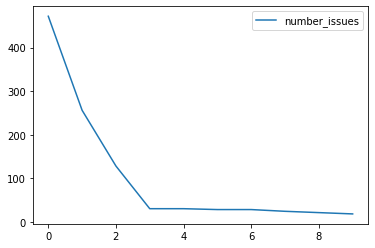

In [60]:
q5r.plot()

-----------